In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
from scipy import integrate
from scipy import special
from scipy import stats
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import network
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar
    
def ytitle(ax,text,xloc=-0.25,**kwargs):
    ax.text(xloc,0.5,text,horizontalalignment='left',verticalalignment='center',
        rotation='vertical',transform=ax.transAxes,**kwargs)

sr2 = np.sqrt(2)
sr2pi = np.sqrt(2*np.pi)

# Simulate Network, Extract Statistics

In [3]:
reload(network)
net = network.Network(NC=10000)

gbar = np.array([-5])
g = np.array([2])
cbar = np.array([5])
c = np.array([0])

g2 = g**2
c2 = c**2

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using",device)

net.set_seed(0)

J = net.generate_gauss_conn(gbar[0],g[0])
print(np.mean(np.sum(J,1)))
print(np.std(np.sum(J,1)))

I = net.generate_gauss_input(cbar[0],c[0])
print(np.mean(I))
print(np.std(I))

J = torch.from_numpy(J).to(device)
I = torch.from_numpy(I).to(device)

Using cpu
-4.9801397
1.9951279
5.0
0.0


In [18]:
tau = np.array([1])
T = tau[0]*torch.ones(net.N,dtype=torch.float32).to(device)

def phi(h):
    return np.fmax(h,0)

relu = torch.nn.ReLU()

Nt = 50*tau[0]
dt = tau[0]/3
int_ts = torch.linspace(0,12*Nt,round(12*Nt/dt)+1).to(device)
mask_time = int_ts>(2*Nt)
int_ts_mask = int_ts[mask_time].cpu().numpy()

In [58]:
# reload(integ)

# start = time.process_time()

# h,r,_ = integ.sim_dyn_tensor(int_ts,relu,T,J,I)

# h_mask = h[:,mask_time].cpu().numpy()
# r_mask = r[:,mask_time].cpu().numpy()
# h = h.cpu().numpy()
# r = r.cpu().numpy()
# htild_mask = h_mask - np.mean(h_mask,-1)[:,None]
# rtild_mask = r_mask - np.mean(r_mask,-1)[:,None]

# print("Integrating network took ",time.process_time() - start," s")
# print('')

# np.save('h_gbar={:.1f}_g={:.1f}_cbar={:.1f}_c={:.1f}'.format(gbar[0],g[0],cbar[0],c[0]),h)

h = np.load('h_gbar={:.1f}_g={:.1f}_cbar={:.1f}_c={:.1f}.npy'.format(gbar[0],g[0],cbar[0],c[0]))
r = phi(h)
h_mask = h[:,mask_time]
r_mask = r[:,mask_time]
htild_mask = h_mask - np.mean(h_mask,-1)[:,None]
rtild_mask = r_mask - np.mean(r_mask,-1)[:,None]

In [8]:
# Ncorr = 150
# Noff = 10
# Nfull = 2*len(int_ts_mask)-1
# Ncent = len(int_ts_mask)-1
# lags = np.arange(Ncorr)*dt

# h_acov = np.zeros(Ncorr)
# r_acov = np.zeros(Ncorr)
# h_xcov = np.zeros(Ncorr)
# r_xcov = np.zeros(Ncorr)
# for i in range(net.N):
#     h_acov += np.correlate(htild_mask[i],htild_mask[i],'full')[Ncent:Ncent+Ncorr]/\
#                             (Ncent+1-np.abs(np.arange(Ncent,Ncent+Ncorr)-Ncent))
#     r_acov += np.correlate(rtild_mask[i],rtild_mask[i],'full')[Ncent:Ncent+Ncorr]/\
#                             (Ncent+1-np.abs(np.arange(Ncent,Ncent+Ncorr)-Ncent))
#     for j in range(np.fmax(i-Noff,0),i):
#         full_xcov = np.correlate(htild_mask[i],htild_mask[j],'full')/\
#                                 (Ncent+1-np.abs(np.arange(Nfull)-Ncent))
#         h_xcov += 0.5*(full_xcov+full_xcov[::-1])[Ncent:Ncent+Ncorr]
#         full_xcov = np.correlate(rtild_mask[i],rtild_mask[j],'full')/\
#                                 (Ncent+1-np.abs(np.arange(Nfull)-Ncent))
#         r_xcov += 0.5*(full_xcov+full_xcov[::-1])[Ncent:Ncent+Ncorr]
        
# h_acov /= net.N
# r_acov /= net.N
# h_xcov /= Noff*net.N - Noff*(Noff+1)//2
# r_xcov /= Noff*net.N - Noff*(Noff+1)//2

In [76]:
h_cov_mat = np.cov(htild_mask)
r_cov_mat = np.cov(rtild_mask)

def off_diag(A):
    return A[~np.eye(A.shape[0],dtype=bool)]

def off_diag_sum(A):
    return np.sum(A)-np.sum(np.diag(A))

In [80]:
lags = np.arange(0,50+1,5)*tau[0]
lag_idxs = np.round(lags / dt).astype(np.int32)

h_xcov_on_0 = np.zeros(len(lags))
h_xcov_on_2 = np.zeros(len(lags))
h_xcov_off_0 = np.zeros(len(lags))
h_xcov_off_2 = np.zeros(len(lags))
r_xcov_on_0 = np.zeros(len(lags))
r_xcov_on_2 = np.zeros(len(lags))
r_xcov_off_0 = np.zeros(len(lags))
r_xcov_off_2 = np.zeros(len(lags))

for idx,lag_idx in enumerate(lag_idxs):
    h_cov_mat = htild_mask[:,lag_idx:]@htild_mask[:,:len(int_ts_mask)-lag_idx].T/(len(int_ts_mask)-lag_idx)
    r_cov_mat = rtild_mask[:,lag_idx:]@rtild_mask[:,:len(int_ts_mask)-lag_idx].T/(len(int_ts_mask)-lag_idx)
    
    h_xcov_on_0[idx] = np.mean(np.diag(h_cov_mat))
    h_xcov_on_2[idx] = np.mean(np.diag(h_cov_mat)**2)
    h_xcov_off_0[idx] = np.mean(off_diag(h_cov_mat))*net.N
    h_xcov_off_2[idx] = np.mean(off_diag(h_cov_mat**2))*net.N
    r_xcov_on_0[idx] = np.mean(np.diag(r_cov_mat))
    r_xcov_on_2[idx] = np.mean(np.diag(r_cov_mat)**2)
    r_xcov_off_0[idx] = np.mean(off_diag(r_cov_mat))*net.N
    r_xcov_off_2[idx] = np.mean(off_diag(r_cov_mat**2))*net.N

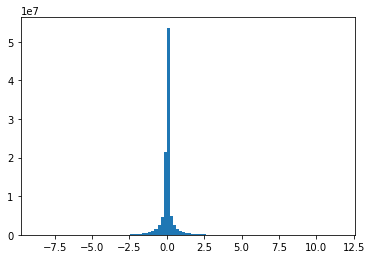

In [57]:
plt.hist(off_diag(r_cov_mat),100)
plt.show()

In [60]:
print('Δtild^0_{on} =',np.mean(np.diag(h_cov_mat)))
print('Δtild^2_{on} =',np.mean(np.diag(h_cov_mat)**2))
print()
print('N Δtild^0_{off} =',np.mean(off_diag(h_cov_mat))*net.N)
print('N Δtild^2_{off} =',np.mean(off_diag(h_cov_mat**2))*net.N)
print()
print('Ctild^0_{on} =',np.mean(np.diag(r_cov_mat)))
print('Ctild^2_{on} =',np.mean(np.diag(r_cov_mat)**2))
print()
print('N Ctild^0_{off} =',np.mean(off_diag(r_cov_mat))*net.N)
print('N Ctild^2_{off} =',np.mean(off_diag(r_cov_mat**2))*net.N)

Δtild^0_{on} = 12.583904027702562
Δtild^2_{on} = 165.42355239575318

N Δtild^0_{off} = 138.31450065182568
N Δtild^2_{off} = 34923.16969657634

Ctild^0_{on} = 3.3543151992517277
Ctild^2_{on} = 28.188691877107402

N Ctild^0_{off} = 3.5995897267644987
N Ctild^2_{off} = 2224.813084852512


In [61]:
np.var(h_mask)

44.03636

In [70]:
Dbar

array([28.288326], dtype=float32)

In [46]:
h_xcov_on_0

array([12.58390403, 12.56331211,  0.        ,  0.        ,  0.        ,
        0.        ])

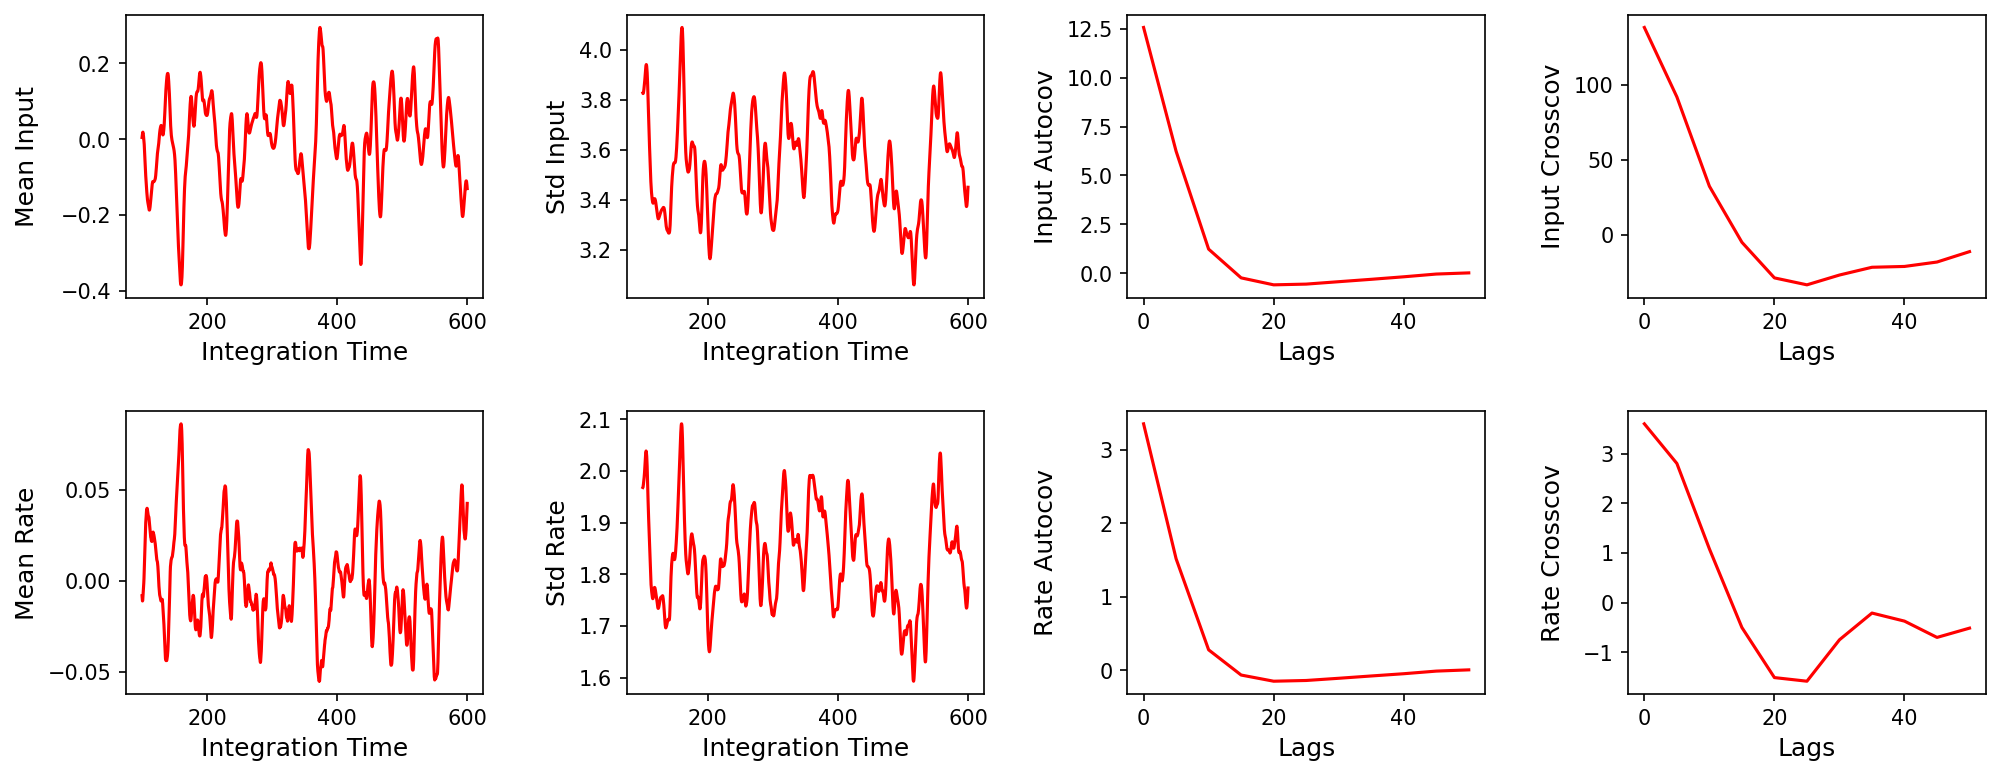

In [81]:
fig,axs = plt.subplots(2,4,figsize=(4*4,3*2),dpi=150)
fig.subplots_adjust(wspace=0.4,hspace=0.4)

axs[0,0].plot(int_ts_mask,np.mean(htild_mask,0),'r-')
axs[1,0].plot(int_ts_mask,np.mean(rtild_mask,0),'r-')

axs[0,1].plot(int_ts_mask,np.std(htild_mask,0),'r-')
axs[1,1].plot(int_ts_mask,np.std(rtild_mask,0),'r-')

axs[0,2].plot(lags,h_xcov_on_0,'r-')
axs[1,2].plot(lags,r_xcov_on_0,'r-')

axs[0,3].plot(lags,h_xcov_off_0,'r-')
axs[1,3].plot(lags,r_xcov_off_0,'r-')

axs[0,0].set_xlabel('Integration Time',fontsize=12)
axs[1,0].set_xlabel('Integration Time',fontsize=12)
axs[0,1].set_xlabel('Integration Time',fontsize=12)
axs[1,1].set_xlabel('Integration Time',fontsize=12)
axs[0,2].set_xlabel('Lags',fontsize=12)
axs[1,2].set_xlabel('Lags',fontsize=12)
axs[0,3].set_xlabel('Lags',fontsize=12)
axs[1,3].set_xlabel('Lags',fontsize=12)

axs[0,0].set_ylabel('Mean Input',fontsize=12)
axs[1,0].set_ylabel('Mean Rate',fontsize=12)
axs[0,1].set_ylabel('Std Input',fontsize=12)
axs[1,1].set_ylabel('Std Rate',fontsize=12)
axs[0,2].set_ylabel('Input Autocov',fontsize=12)
axs[1,2].set_ylabel('Rate Autocov',fontsize=12)
axs[0,3].set_ylabel('Input Crosscov',fontsize=12)
axs[1,3].set_ylabel('Rate Crosscov',fontsize=12)

fig.align_labels()

# Solve Single-Site DMFT

In [63]:
def phi_n(n,x):
    return np.fmax(x,0)**n

def mean_n(n,x):
    pdf = np.exp(-0.5*x**2)/sr2pi
    cdf = 0.5*(1+special.erf(x/sr2))
    
    if n == -6:
        return -x*(x**4-10*x**2+15)*pdf
    if n == -5:
        return (x**4-6*x**2+3)*pdf
    if n == -4:
        return -x*(x**2-3)*pdf
    elif n == -3:
        return (x**2-1)*pdf
    elif n == -2:
        return -x*pdf
    elif n == -1:
        return pdf
    elif n == 0:
        return cdf
    elif n == 1:
        return pdf+x*cdf
    elif n == 2:
        return x*pdf+(1+x**2)*cdf
    elif n == 3:
        return (2+x**2)*pdf+x*(3+x**2)*cdf
    elif n == 4:
        return x*(5+x**2)*pdf+(3+6*x**2+x**4)*cdf
    elif n == 5:
        return (8+9*x**2+x**4)*pdf+x*(15+10*x**2+x**4)*cdf
    elif n == 6:
        return x*(3+x**2)*(11+x**2)*pdf+(15+45*x**2+15*x**4+x**6)*cdf
    elif n == 7:
        return (48+87*x**2+20*x**4+x**6)*pdf+x*(105+105*x**2+21*x**4+x**6)*cdf
    elif n == 8:
        return x*(279+185*x**2+27*x**4+x**6)*pdf+(105+420*x**2+210*x**4+28*x**6+x**8)*cdf
    else:
        raise('n not supported')
        
def xcorr_n(n,x1,x2,c):
    if x1 > x2:
        xi = x1
        xj = x2
    else:
        xi = x2
        xj = x1
        
    if n == 0:
        A = mean_n(0,xj)
    elif n == 1:
        A = xi*mean_n(1,xj) + mean_n(0,xj)
    elif n == 2:
        A = (1+xi**2)*mean_n(2,xj) + 4*xi*mean_n(1,xj) + 2*mean_n(0,xj)
    elif n == 3:
        A = xi*(3+xi**2)*mean_n(3,xj) + 9*(1+xi**2)*mean_n(2,xj) + 18*xi*mean_n(1,xj) + 6*mean_n(0,xj)
    else:
        raise('n not supported')

    if x1 > - x2:
        pdf1 = np.exp(-0.5*x1**2)/sr2pi
        pdf2 = np.exp(-0.5*x2**2)/sr2pi
        cdf1 = 0.5*(1+special.erf(x1/sr2))
        cdf2 = 0.5*(1+special.erf(x2/sr2))
        if n == 0:
            B = cdf1+cdf2-1
        elif n == 1:
            B = (x1*x2-1)*(cdf1+cdf2-1) + x1*pdf2+x2*pdf1
        elif n == 2:
            B = (x1**2*x2**2+x1**2+x2**2-4*x1*x2+3)*(cdf1+cdf2-1) +\
                (x1*(1+x2**2)-4*x2)*pdf1 + (x2*(1+x1**2)-4*x1)*pdf2
        elif n == 3:
            B = (x1**3*x2**3+3*(x1**3*x2+x1*x2**3)-9*(x1**2*x2**2+x1**2+x2**2)+\
                    27*x1*x2-15)*(cdf1+cdf2-1) +\
                (x1**2*x2*(3+x2**2)-9*x1*(1+x2**2)+2*x2*(12+x2**2))*pdf1 +\
                (x2**2*x1*(3+x1**2)-9*x2*(1+x1**2)+2*x1*(12+x1**2))*pdf2
        else:
            raise('n not supported')
    else:
        B = 0

    r1 = mean_n(n,x1)
    r2 = mean_n(n,x2)

    Lp = A-r1*r2
    Lm = B-r1*r2

    a0 = r1*r2
    a1 = n**2*mean_n(n-1,x1)*mean_n(n-1,x2)
    a2 = (n*np.fmax(n-1,1))**2*mean_n(n-2,x1)*mean_n(n-2,x2)/2
    a3 = (n*np.fmax(n-1,1)*np.fmax(n-2,1))**2*mean_n(n-3,x1)*mean_n(n-3,x2)/6
    a4 = (n*np.fmax(n-1,1)*np.fmax(n-2,1)*np.fmax(n-3,1))**2*mean_n(n-4,x1)*mean_n(n-4,x2)/24
    a5 = (n*np.fmax(n-1,1)*np.fmax(n-2,1)*np.fmax(n-3,1)*np.fmax(n-4,1))**2*mean_n(n-5,x1)*mean_n(n-5,x2)/120
    a6 = (Lp+Lm)/2 - a2 - a4
    a7 = (Lp-Lm)/2 - a1 - a3 - a5

    return a0 + a1*c + a2*c**2 + a3*c**3 + a4*c**4 + a5*c**5 + a6*c**6 + a7*c**7

In [64]:
def mean(u,D,n=1):
    if D == 0.0:
        return phi_n(n,u)
    else:
        return np.sqrt(D)**n * mean_n(n,u/np.sqrt(D))

def xcorr(u1,u2,D11,D22,D12,n=1):
    if D12 == 0.0:
        return mean(u1,D11,n)*mean(u2,D22,n)
    
    if D11 == 0.0 or D22 == 0.0:
        c = 0.0
    else:
        c = np.sign(D12)*np.fmin(np.abs(D12)/np.sqrt(D11*D22),1)
        
    return (np.sqrt(D11)*np.sqrt(D22))**n * xcorr_n(n,u1/np.sqrt(D11),u2/np.sqrt(D22),c)

def acorr(u,D,rho,n=1):
    return xcorr(u,u,D,D,rho,n)

def mean_P(u,D,n=1):
    out = np.zeros_like(u)
    for i in range(len(u)):
        out[i] = mean(u[i],D[i],n)
    return out

def acorr_P(u,D,rho,n=1):
    out = np.zeros_like(u)
    for i in range(len(u)):
        out[i] = acorr(u[i],D[i],rho[i],n)
    return out

def mean_fn(u,D,out,n=1):
    for i in range(len(u)):
        out[i] = mean(u[i],D[i],n)

def acorr_fn(u,D,rho,out,n=1):
    for i in range(len(u)):
        out[i] = acorr(u[i],D[i],rho[i],n)

In [65]:
def each_diag(A):
    return np.einsum('ijj->ij',A)

def each_matmul(A,B):
    return np.einsum('ijk,jk->ik',A,B)

def grid_stat(stat,A,Tstat,dt):
    Ntyp = A.shape[0]
    Nsav = A.shape[1]
    Nstat = round(Tstat/dt)+1
    A_ext = np.zeros((Ntyp,Nstat))
    if Nsav < Nstat:
        A_ext[:,:Nsav] = A
        A_ext[:,Nsav:] = A[:,-1:]
    else:
        A_ext = A[:,:Nstat]
    A_mat = np.array([toeplitz(A_ext[typ_idx]) for typ_idx in range(Ntyp)])
    return stat(A_mat,axis=(1,2))

In [66]:
def one_site_dmft(tau,gbar,g,cbar,c,mean_fn,acorr_fn,Twrm,Tsav,dt,u0=None,D0=None):
    NP = len(cbar)
    Nint = round((Twrm+Tsav)/dt)+1
    Nclc = round(1.5*Tsav/dt)+1
    Nsav = round(Tsav/dt)+1
    
    u = np.zeros((NP,Nint),dtype=np.float32)
    D = np.zeros((NP,Nint,Nint),dtype=np.float32)
    
    if u0 is None:
        u0 = 1e-8*np.ones((NP),dtype=np.float32)
    if D0 is None:
        D0 = 1e2*np.ones((NP,1),dtype=np.float32)
        
    g2 = g**2
    c2 = c**2
        
    tau_inv = 1/tau
    dt_tau_inv = dt/tau
    dt_tau_inv2 = dt_tau_inv**2
    
    u[:,0] = u0
    
    ND0 = D0.shape[1]
    if Nclc > ND0:
        D[:,0,:ND0] = D0
        D[:,0,ND0:Nclc] = D0[:,-1:]
        D[:,:ND0,0] = D0
        D[:,ND0:Nclc,0] = D0[:,-1:]
    else:
        D[:,0,:Nclc] = D0[:,:Nclc]
        D[:,:Nclc,0] = D0[:,:Nclc]
        
    m = np.empty((NP),dtype=np.float32)
    C = np.empty((NP),dtype=np.float32)
    
    for i in range(Nint-1):
        ui = u[:,i]
        Dii = D[:,i,i]
        mean_fn(ui,Dii,m)
        k1 = tau_inv*(-ui + gbar@m + cbar)
        
        ui = u[:,i] + 0.5*dt*k1
        mean_fn(ui,Dii,m)
        k2 = tau_inv*(-ui + gbar@m + cbar)
        
        ui = u[:,i] + 0.5*dt*k2
        mean_fn(ui,Dii,m)
        k3 = tau_inv*(-ui + gbar@m + cbar)
        
        ui = u[:,i] + dt*k3
        mean_fn(ui,Dii,m)
        k4 = tau_inv*(-ui + gbar@m + cbar)
        
        u[:,i+1] = u[:,i] + dt/6*(k1+2*k2+2*k3+k4)
        ui = u[:,i]
        mean_fn(ui,Dii,m)
        
        if np.any(np.abs(u[:,i+1]) > 1e10) or np.any(np.isnan(u[:,i+1])):
            print("system diverged when integrating u")
            return u,D,False

        if i > Nclc-1:
            D[:,i+1,i-Nclc] = D[:,i,i-Nclc]
            
        for j in range(max(0,i-Nclc),i+1):
            Dij = D[:,i,j]
            acorr_fn(ui,Dii,Dij,C)
            D[:,i+1,j+1] = D[:,i,j+1]+D[:,i+1,j]-D[:,i,j] +\
                dt_tau_inv*(-D[:,i+1,j]-D[:,i,j+1]+2*D[:,i,j]) +\
                dt_tau_inv2*(-D[:,i,j]+g2@C+c2)
            
            if np.any(np.abs(D[:,i+1,j+1]) > 1e10) or np.any(np.isnan(D[:,i+1,j+1])):
                print("system diverged when integrating D")
                return u,D,False
                
            D[:,j+1,i+1] = D[:,i+1,j+1]
            
        Ndiv = 5
        if (Ndiv*(i+1)) % (Nint-1) == 0:
            print("{:.2f}% completed".format((i+1)/(Nint-1)))
            
    D_diag = each_diag(D)
    
    return u,D,\
        (np.max(D_diag[:,-Nsav:],axis=1)-np.min(D_diag[:,-Nsav:],axis=1))/\
            np.mean(D_diag[:,-Nsav:],axis=1) < 1e-3

In [67]:
Twrm = 200
Tsav = 50
dmft_dt = 1/4
NP = 1
Nint = round((Twrm+Tsav)/dmft_dt)+1
Nclc = round(1.5*Tsav/dmft_dt)+1
Nsav = round(Tsav/dmft_dt)+1

start = time.process_time()

full_u,full_D,conv = one_site_dmft(tau,gbar,g,cbar,c,mean_fn,acorr_fn,Twrm,Tsav,dmft_dt)

print("Solving single site DMFT took ",time.process_time() - start," s")
print('')

print(conv)

full_m = np.zeros_like(full_u)
full_C = np.zeros_like(full_D)
for i in range(Nint):
    mean_fn(full_u[:,i],full_D[:,i,i],full_m[:,i])
    for j in range(max(0,i-Nclc),i+1):
        acorr_fn(full_u[:,i],full_D[:,i,i],full_D[:,i,j],full_C[:,i,j])
        full_C[:,j,i] = full_C[:,i,j]

u = full_u[:,-1]
D = full_D[:,-1,-1:-Nsav-1:-1]

m = np.zeros_like(u)
C = np.zeros_like(D)
mean_fn(u,D[:,0],m)
for i in range(Nsav):
    acorr_fn(u,D[:,0],D[:,i],C[:,i])

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
Solving single site DMFT took  63.5693839999999  s

[ True]


In [68]:
Dbar = D[:,-1]
Cbar = C[:,-1]
Dtild = D - Dbar
Ctild = C - Cbar

X = np.exp(-np.arange(Nsav)[None,:]*dmft_dt/tau)
S = mean_P(u,D[:,0],n=0)*X

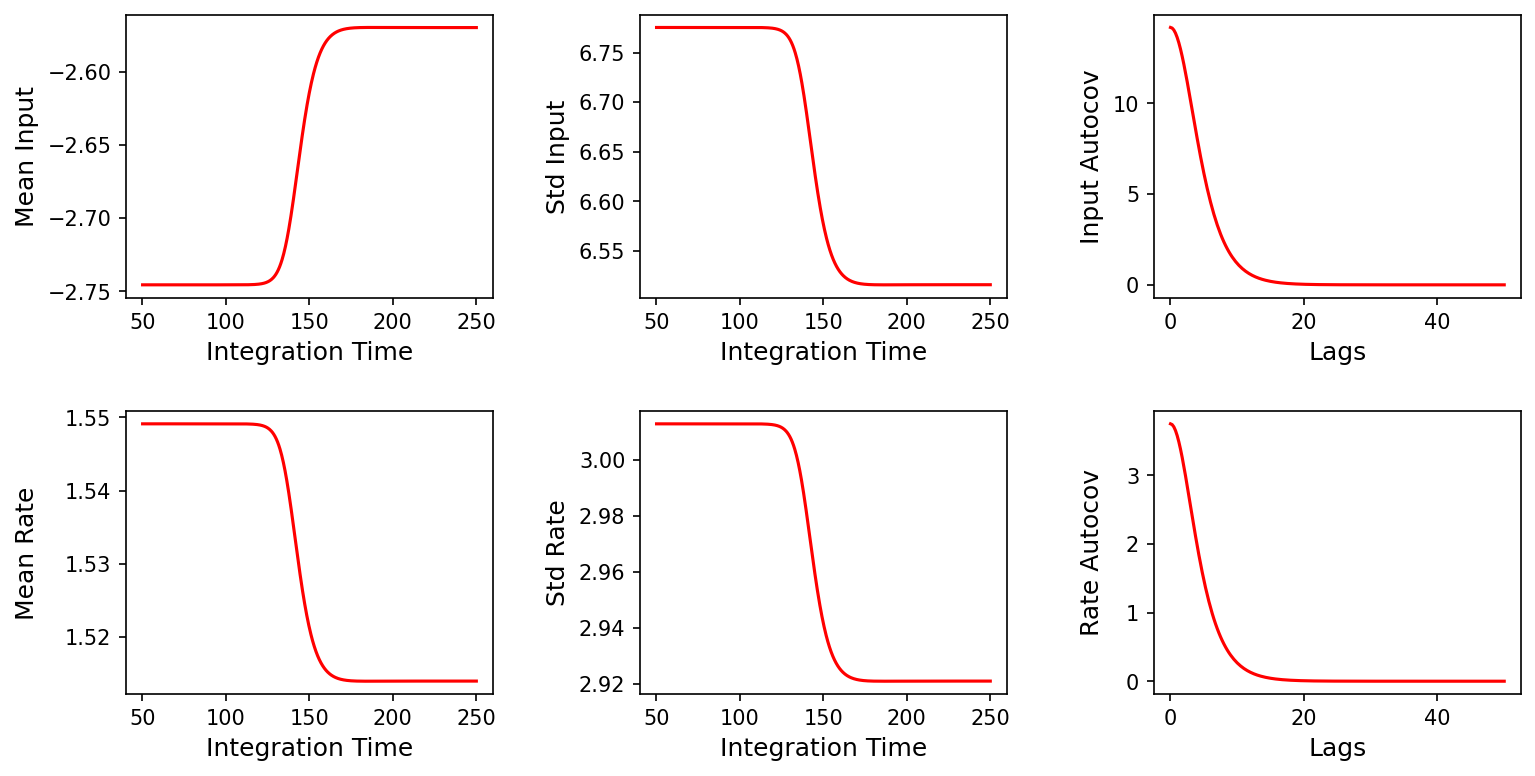

In [69]:
full_int_ts = np.arange(Nint)*dmft_dt
dmft_mask_time = full_int_ts > 50
dmft_lags = np.arange(Nsav)*dmft_dt
mask_full_int_ts = full_int_ts[dmft_mask_time]
mask_full_u = full_u[:,dmft_mask_time]
mask_full_D = full_D[:,dmft_mask_time][:,:,dmft_mask_time]
mask_full_m = full_m[:,dmft_mask_time]
mask_full_C = full_C[:,dmft_mask_time][:,:,dmft_mask_time]

fig,axs = plt.subplots(2,3,figsize=(4*3,3*2),dpi=150)
fig.subplots_adjust(wspace=0.4,hspace=0.4)

axs[0,0].plot(mask_full_int_ts,mask_full_u[0],'r-')
axs[1,0].plot(mask_full_int_ts,mask_full_m[0],'r-')

axs[0,1].plot(mask_full_int_ts,np.sqrt(np.fmax(np.diag(mask_full_D[0]),0)),'r-')
axs[1,1].plot(mask_full_int_ts,np.sqrt(np.fmax(np.diag(mask_full_C[0])-mask_full_m[0]**2,0)),'r-')

axs[0,2].plot(dmft_lags,Dtild[0],'r-')
axs[1,2].plot(dmft_lags,Ctild[0],'r-')

axs[0,0].set_xlabel('Integration Time',fontsize=12)
axs[1,0].set_xlabel('Integration Time',fontsize=12)
axs[0,1].set_xlabel('Integration Time',fontsize=12)
axs[1,1].set_xlabel('Integration Time',fontsize=12)
axs[0,2].set_xlabel('Lags',fontsize=12)
axs[1,2].set_xlabel('Lags',fontsize=12)

axs[0,0].set_ylabel('Mean Input',fontsize=12)
axs[1,0].set_ylabel('Mean Rate',fontsize=12)
axs[0,1].set_ylabel('Std Input',fontsize=12)
axs[1,1].set_ylabel('Std Rate',fontsize=12)
axs[0,2].set_ylabel('Input Autocov',fontsize=12)
axs[1,2].set_ylabel('Rate Autocov',fontsize=12)

fig.align_labels()

# Solve Two-Site Cavity DMFT

## Fourier Transform $\tilde{C}$ and $S$

In [435]:
Tlong = 400
Nlong = round(Tlong/dmft_dt)

ts = np.concatenate((np.arange(Nlong//2),-np.arange(Nlong//2+1)[:0:-1]))*dmft_dt

Ctild_t = np.zeros((NP,Nlong))
Ctild_t[:,:Nsav] = Ctild
Ctild_t[:,-Nsav+1:] = Ctild[:,:0:-1]

S_t = np.zeros((NP,Nlong))
S_t[:,:Nsav] = S

fs = np.fft.fftfreq(Nlong,dmft_dt)
os = fs*2*np.pi

Ctild_f = np.real(np.fft.fft(Ctild_t)) * dmft_dt
Ctild_o = Ctild_f / sr2pi

S_f = mean_P(u,D[:,0],n=0)/(1+1j*tau*os[None,:])
S_o = S_f / sr2pi

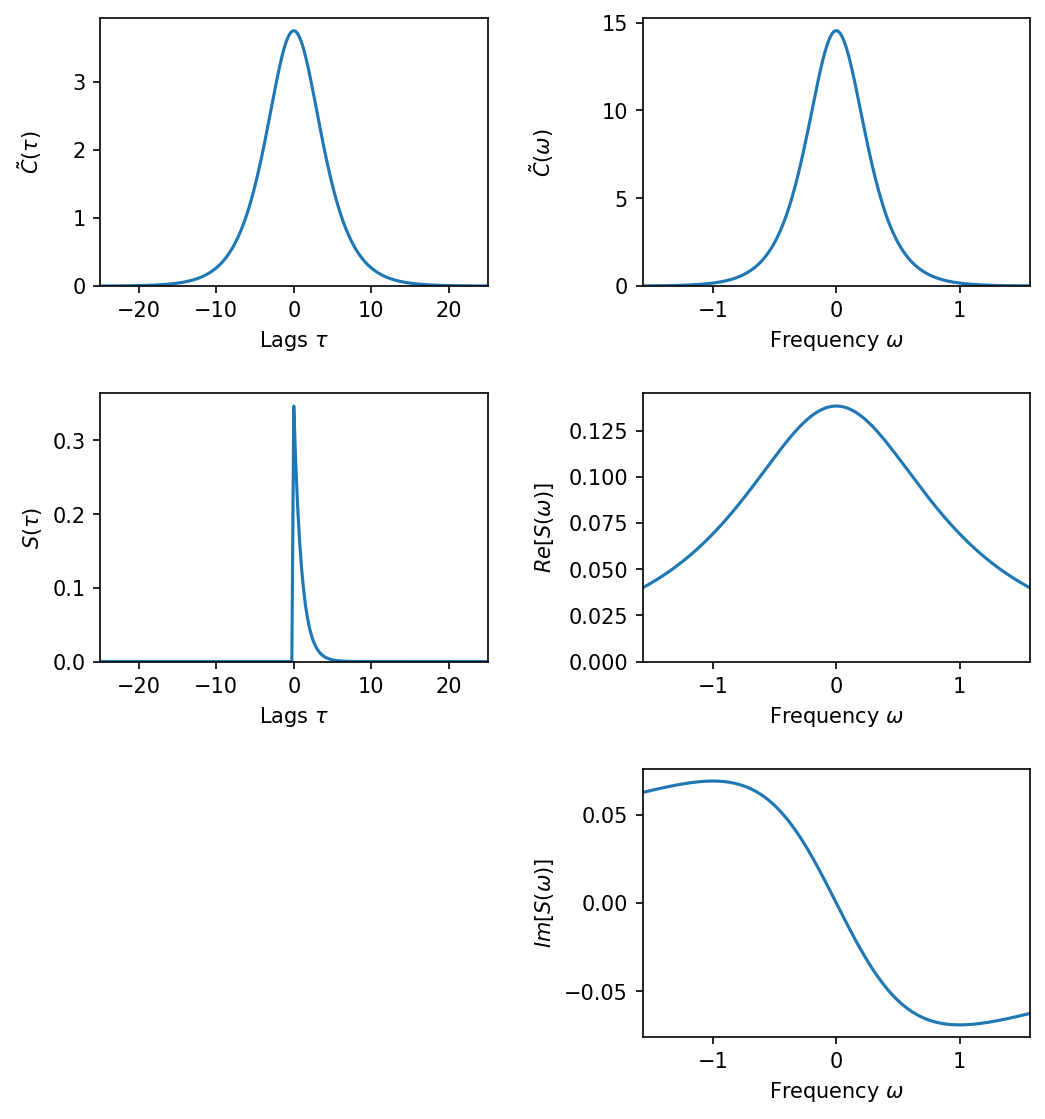

In [430]:
fig,axs = plt.subplots(3,2,figsize=(4*2,3*3),dpi=150)
fig.subplots_adjust(wspace=0.4,hspace=0.4)

t_idx = np.argsort(ts)
o_idx = np.argsort(os)

tlim = 25
olim = 0.25*2*np.pi

axs[0,0].plot(ts[t_idx],Ctild_t[0,t_idx])
axs[0,1].plot(os[o_idx],Ctild_o[0,o_idx])
axs[1,0].plot(ts[t_idx],S_t[0,t_idx])
axs[1,1].plot(os[o_idx],np.real(S_o[0,o_idx]))
axs[2,1].plot(os[o_idx],np.imag(S_o[0,o_idx]))
axs[2,0].axis('off')

axs[0,0].set_xlim(-tlim,tlim)
axs[0,1].set_xlim(-olim,olim)
axs[1,0].set_xlim(-tlim,tlim)
axs[1,1].set_xlim(-olim,olim)
axs[2,1].set_xlim(-olim,olim)

axs[0,0].set_ylim(0,None)
axs[0,1].set_ylim(0,None)
axs[1,0].set_ylim(0,None)
axs[1,1].set_ylim(0,None)

axs[0,0].set_xlabel(r'Lags $\tau$')
axs[0,1].set_xlabel(r'Frequency $\omega$')
axs[1,0].set_xlabel(r'Lags $\tau$')
axs[1,1].set_xlabel(r'Frequency $\omega$')
axs[2,1].set_xlabel(r'Frequency $\omega$')

axs[0,0].set_ylabel(r'$\tilde{C}(\tau)$')
axs[0,1].set_ylabel(r'$\tilde{C}(\omega)$')
axs[1,0].set_ylabel(r'$S(\tau)$')
axs[1,1].set_ylabel(r'$Re[S(\omega)]$')
axs[2,1].set_ylabel(r'$Im[S(\omega)]$')

fig.align_labels()

## Calculate Mean of Off-Diagonal $\tilde{C}$

In [502]:
psiC_0_o = 2*np.real(S_o)*Ctild_o / np.sqrt(2*np.pi)
psiC_0_f = psiC_0_o * np.sqrt(2*np.pi)

psiC_0_t = np.real(np.fft.ifft(psiC_0_f)) / dmft_dt

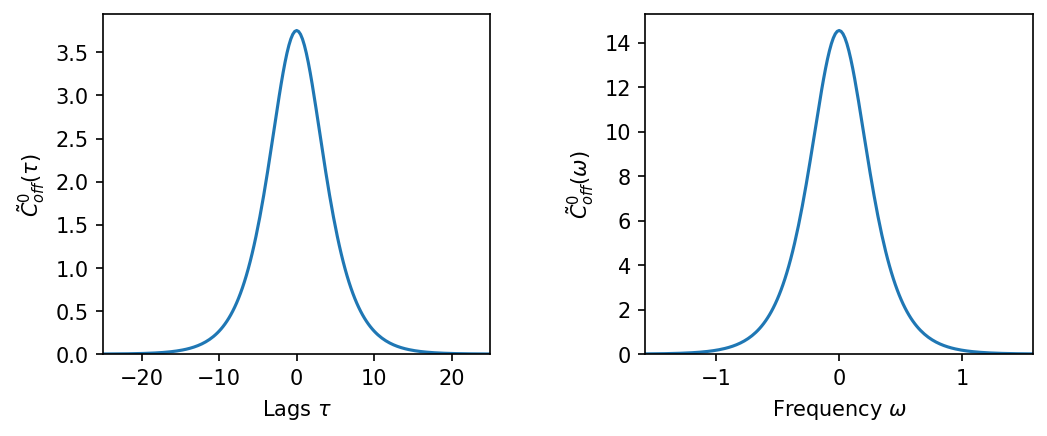

In [504]:
fig,axs = plt.subplots(1,2,figsize=(4*2,3*1),dpi=150)
fig.subplots_adjust(wspace=0.4,hspace=0.4)

t_idx = np.argsort(ts)
o_idx = np.argsort(os)

tlim = 25
olim = 0.25*2*np.pi

axs[0].plot(ts[t_idx],Ctild_t[0,t_idx])
axs[1].plot(os[o_idx],Ctild_o[0,o_idx])

axs[0].set_xlim(-tlim,tlim)
axs[1].set_xlim(-olim,olim)

axs[0].set_ylim(0,None)
axs[1].set_ylim(0,None)

axs[0].set_xlabel(r'Lags $\tau$')
axs[1].set_xlabel(r'Frequency $\omega$')

axs[0].set_ylabel(r'$\tilde{C}^0_{off}(\tau)$')
axs[1].set_ylabel(r'$\tilde{C}^0_{off}(\omega)$')

fig.align_labels()

## Calculate Two-Pt Fn of Diagonal $\tilde{C}$ and $S$

In [393]:
sbar = np.sqrt(Dbar)

start = time.process_time()

Ctild2 = np.zeros((NP,Nsav,Nsav))
for i in range(Nsav):
    for j in range(i,Nsav):
        if Ctild[0,i]*Ctild[0,j] < 1e-6:
            continue
        def Ctild2_fn(x):
            return (acorr(u[0]+x*sbar[0],Dtild[0,0],Dtild[0,i])-mean(u[0]+x*sbar[0],Dtild[0,0])**2) *\
                   (acorr(u[0]+x*sbar[0],Dtild[0,0],Dtild[0,j])-mean(u[0]+x*sbar[0],Dtild[0,0])**2) *\
                   np.exp(-0.5*x**2)/sr2pi
        Ctild2[0,i,j] = integrate.quad(Ctild2_fn,-8,8)[0]
        Ctild2[:,j,i] = Ctild2[:,i,j]

print(r"Calculating $\tilde{C}^2$ took ",time.process_time() - start," s")
print('')
        
S2 = acorr_P(u,D[:,0],Dbar,n=0)[:,None,None]*np.einsum('ij,ik->ijk',X,X)

Calculating 	ilde{C}^2 took  812.0237129999998  s



In [394]:
Ctild2_t = np.zeros((NP,Nlong,Nlong))
Ctild2_t[:,:Nsav,:Nsav] = Ctild2
Ctild2_t[:,:Nsav,-Nsav+1:] = Ctild2[:,:,:0:-1]
Ctild2_t[:,-Nsav+1:,:Nsav] = Ctild2[:,:0:-1,:]
Ctild2_t[:,-Nsav+1:,-Nsav+1:] = Ctild2[:,:0:-1,:0:-1]

S2_t = np.zeros((NP,Nlong,Nlong))
S2_t[:,:Nsav,:Nsav] = S2

Ctild2_f = np.real(np.fft.fft2(Ctild2_t)) * dmft_dt**2
Ctild2_o = Ctild2_f / (2*np.pi)

S2_f = acorr_P(u,D[:,0],Dbar,n=0)[:,None,None]/\
    ((1+1j*tau[:,None,None]*os[None,:,None])*(1+1j*tau[:,None,None]*os[None,None,:]))
S2_o = S2_f / (2*np.pi)

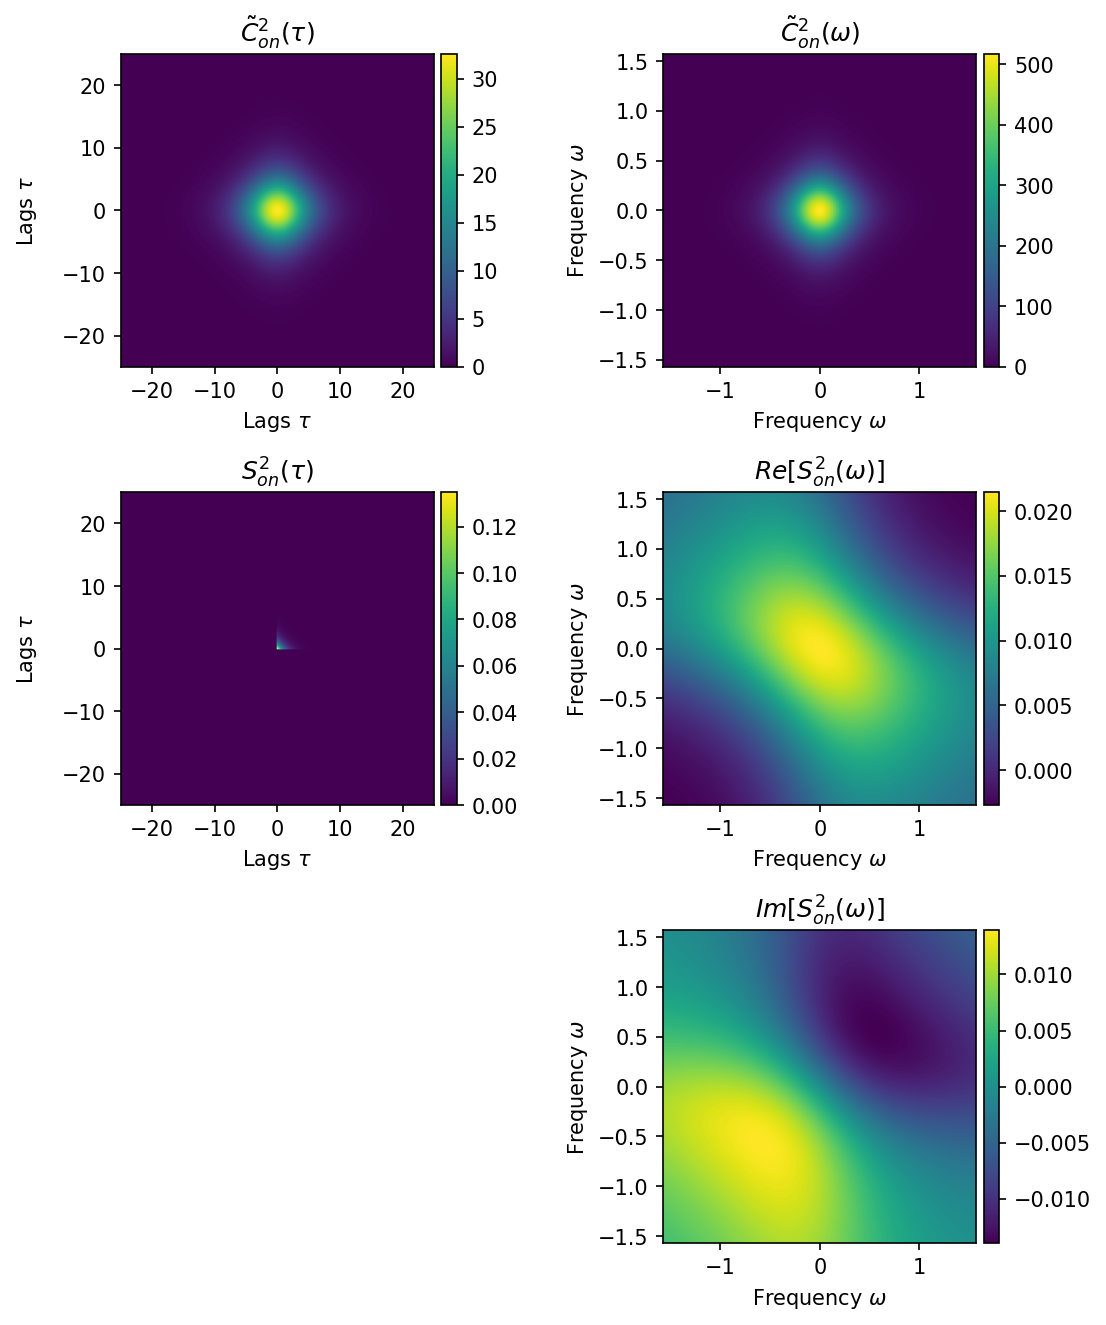

In [475]:
fig,axs = plt.subplots(3,2,figsize=(4*2,3.5*3),dpi=150)
fig.subplots_adjust(wspace=0.4,hspace=0.4)

t_idx = np.argsort(ts)
o_idx = np.argsort(os)

tlim = 25
olim = 0.25*2*np.pi

imshowbar(fig,axs[0,0],Ctild2_t[0,t_idx][:,t_idx],origin='lower',
          extent=(np.min(ts),np.max(ts),np.min(ts),np.max(ts)))
imshowbar(fig,axs[0,1],Ctild2_o[0,o_idx][:,o_idx],origin='lower',
          extent=(np.min(os),np.max(os),np.min(os),np.max(os)))
imshowbar(fig,axs[1,0],S2_t[0,t_idx][:,t_idx],origin='lower',
          extent=(np.min(ts),np.max(ts),np.min(ts),np.max(ts)))
imshowbar(fig,axs[1,1],np.real(S2_o[0,t_idx][:,t_idx]),origin='lower',
          extent=(np.min(os),np.max(os),np.min(os),np.max(os)))
imshowbar(fig,axs[2,1],np.imag(S2_o[0,t_idx][:,t_idx]),origin='lower',
          extent=(np.min(os),np.max(os),np.min(os),np.max(os)))
axs[2,0].axis('off')

axs[0,0].set_xlim(-tlim,tlim)
axs[0,1].set_xlim(-olim,olim)
axs[1,0].set_xlim(-tlim,tlim)
axs[1,1].set_xlim(-olim,olim)
axs[2,1].set_xlim(-olim,olim)

axs[0,0].set_ylim(-tlim,tlim)
axs[0,1].set_ylim(-olim,olim)
axs[1,0].set_ylim(-tlim,tlim)
axs[1,1].set_ylim(-olim,olim)
axs[2,1].set_ylim(-olim,olim)

axs[0,0].set_xlabel(r'Lags $\tau$')
axs[0,1].set_xlabel(r'Frequency $\omega$')
axs[1,0].set_xlabel(r'Lags $\tau$')
axs[1,1].set_xlabel(r'Frequency $\omega$')
axs[2,1].set_xlabel(r'Frequency $\omega$')

axs[0,0].set_ylabel(r'Lags $\tau$')
axs[0,1].set_ylabel(r'Frequency $\omega$')
axs[1,0].set_ylabel(r'Lags $\tau$')
axs[1,1].set_ylabel(r'Frequency $\omega$')
axs[2,1].set_ylabel(r'Frequency $\omega$')

axs[0,0].set_title(r'$\tilde{C}^2_{on}(\tau)$')
axs[0,1].set_title(r'$\tilde{C}^2_{on}(\omega)$')
axs[1,0].set_title(r'$S^2_{on}(\tau)$')
axs[1,1].set_title(r'$Re[S^2_{on}(\omega)]$')
axs[2,1].set_title(r'$Im[S^2_{on}(\omega)]$')

fig.align_labels()

## Calculate Two-Pt Fn of Off-Diagonal $F$

In [463]:
F2_o = g2[:,None,None] / (2*np.pi*(1-2*np.pi*g2[:,None,None]*S2_o))
F2_f = F2_o * (2*np.pi)

F2_t = np.fft.ifft2(F2_f) / dmft_dt**2

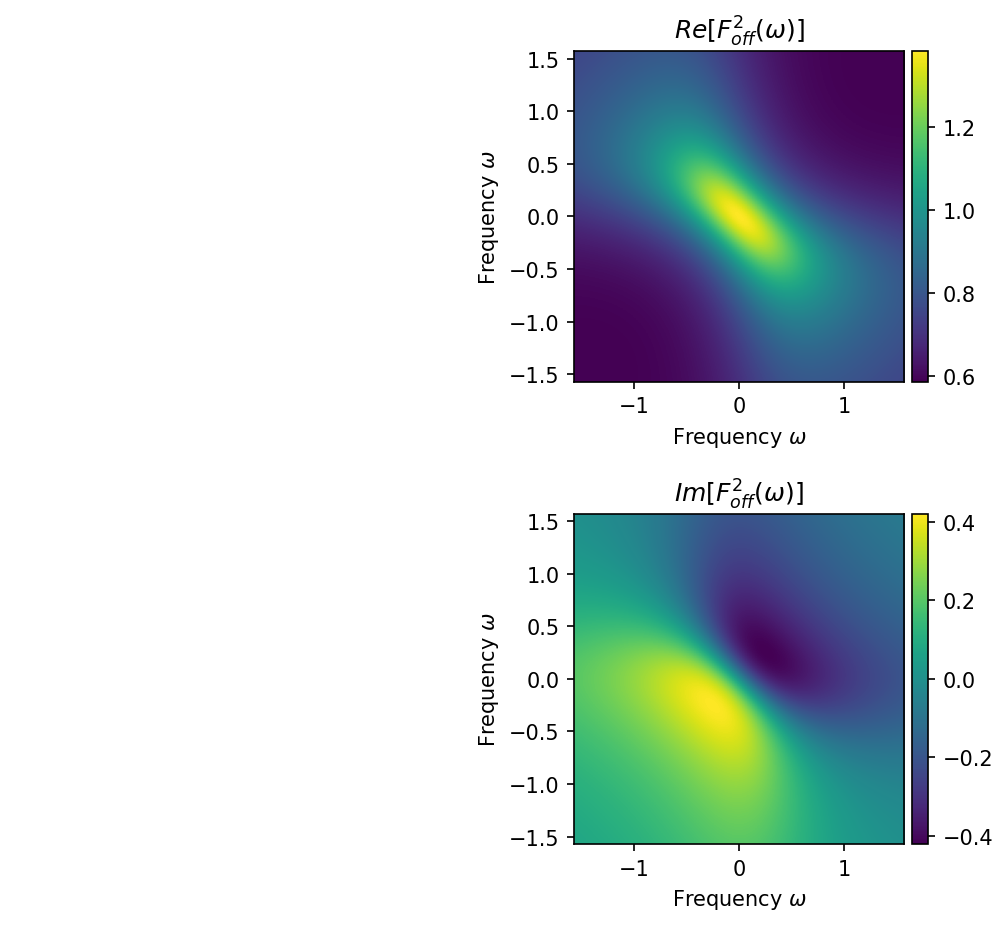

In [512]:
fig,axs = plt.subplots(2,2,figsize=(4*2,3.5*2),dpi=150)
fig.subplots_adjust(wspace=0.4,hspace=0.4)

t_idx = np.argsort(ts)
o_idx = np.argsort(os)

tlim = 25
olim = 0.25*2*np.pi

# imshowbar(fig,axs[0,0],np.real(F2_t[0,t_idx][:,t_idx]),origin='lower',
#           extent=(np.min(ts),np.max(ts),np.min(ts),np.max(ts)))
# imshowbar(fig,axs[1,0],np.imag(F2_t[0,t_idx][:,t_idx]),origin='lower',
#           extent=(np.min(ts),np.max(ts),np.min(ts),np.max(ts)))
axs[0,0].axis('off')
axs[1,0].axis('off')
imshowbar(fig,axs[0,1],np.real(F2_o[0,o_idx][:,o_idx]),origin='lower',
          extent=(np.min(os),np.max(os),np.min(os),np.max(os)))
imshowbar(fig,axs[1,1],np.imag(F2_o[0,o_idx][:,o_idx]),origin='lower',
          extent=(np.min(os),np.max(os),np.min(os),np.max(os)))

# axs[0,0].set_xlim(-tlim,tlim)
# axs[1,0].set_xlim(-tlim,tlim)
axs[0,1].set_xlim(-olim,olim)
axs[1,1].set_xlim(-olim,olim)

# axs[0,0].set_ylim(-tlim,tlim)
# axs[1,0].set_ylim(-tlim,tlim)
axs[0,1].set_ylim(-olim,olim)
axs[1,1].set_ylim(-olim,olim)

# axs[0,0].set_xlabel(r'Lags $\tau$')
# axs[1,0].set_xlabel(r'Lags $\tau$')
axs[0,1].set_xlabel(r'Frequency $\omega$')
axs[1,1].set_xlabel(r'Frequency $\omega$')

# axs[0,0].set_ylabel(r'Lags $\tau$')
# axs[1,0].set_ylabel(r'Lags $\tau$')
axs[0,1].set_ylabel(r'Frequency $\omega$')
axs[1,1].set_ylabel(r'Frequency $\omega$')

# axs[0,0].set_title(r'$Re[F^2_{off}(\tau)]$')
# axs[1,0].set_title(r'$Im[F^2_{off}(\tau)]$')
axs[0,1].set_title(r'$Re[F^2_{off}(\omega)]$')
axs[1,1].set_title(r'$Im[F^2_{off}(\omega)]$')

fig.align_labels()

## Calculate Two-Pt Fn of Off-Diagonal $\tilde{C}$

In [500]:
psiC_2_o = (1/np.abs(1-2*np.pi*g2[:,None,None]*S2_o)**2 - 1) * Ctild2_o
psiC_2_f = psiC_2_o * (2*np.pi)

psiC_2_t = np.real(np.fft.ifft2(psiC_2_f)) / dmft_dt**2

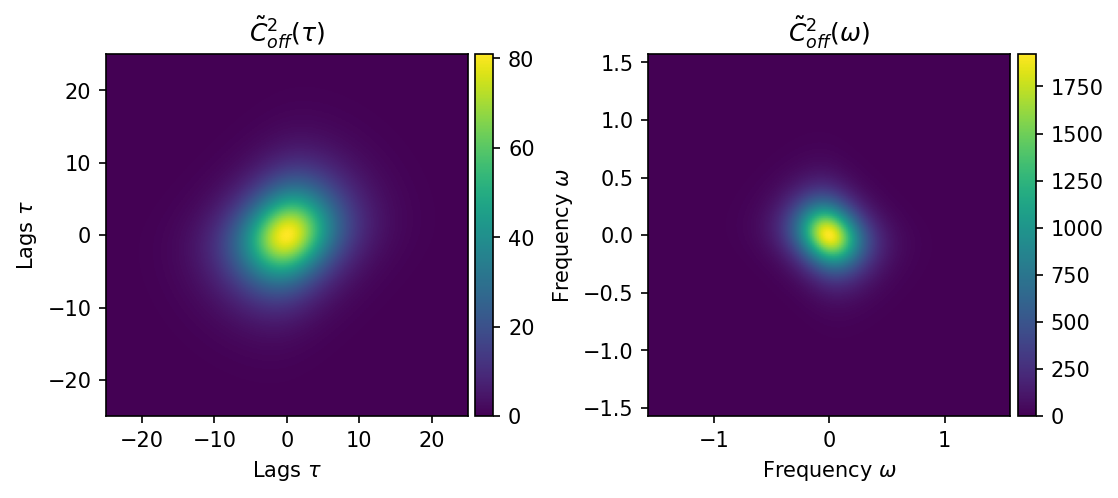

In [501]:
fig,axs = plt.subplots(1,2,figsize=(4*2,3.5*1),dpi=150)
fig.subplots_adjust(wspace=0.4,hspace=0.4)

t_idx = np.argsort(ts)
o_idx = np.argsort(os)

tlim = 25
olim = 0.25*2*np.pi

imshowbar(fig,axs[0],np.real(psiC_2_t[0,t_idx][:,t_idx]),origin='lower',
          extent=(np.min(ts),np.max(ts),np.min(ts),np.max(ts)))
imshowbar(fig,axs[1],np.real(psiC_2_o[0,o_idx][:,o_idx]),origin='lower',
          extent=(np.min(os),np.max(os),np.min(os),np.max(os)))

axs[0].set_xlim(-tlim,tlim)
axs[1].set_xlim(-olim,olim)

axs[0].set_ylim(-tlim,tlim)
axs[1].set_ylim(-olim,olim)

axs[0].set_xlabel(r'Lags $\tau$')
axs[1].set_xlabel(r'Frequency $\omega$')

axs[0].set_ylabel(r'Lags $\tau$')
axs[1].set_ylabel(r'Frequency $\omega$')

axs[0].set_title(r'$\tilde{C}^2_{off}(\tau)$')
axs[1].set_title(r'$\tilde{C}^2_{off}(\omega)$')

fig.align_labels()